In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(10)
import networkx as nx
import math
from numpy import linalg as LA
from itertools import permutations

In [2]:
def positiveMatrix(X):
  result = np.where(X<0, 0, X)
  return result

In [3]:
# Generate MaxWeight service matrix for the given nxn queue switch matrix
def generateMaxWeightServiceMatrix(n, q):
  bipartite_graph = nx.complete_bipartite_graph(n,n)
  s = np.zeros((n,n))
  for e,(u,v) in enumerate(bipartite_graph.edges()):
    bipartite_graph[u][v]['weight'] = q[u][v-n]

  max_weight_match = nx.max_weight_matching(bipartite_graph,maxcardinality=True)
	
  for e,(u,v) in enumerate(max_weight_match):
    s[u][v-n] = 1
  return s

In [4]:
# Given size of the switch n, design a permutation matrix
def generateRandomServiceMatrix(n):
  num_arr = np.arange(n)
  perm_mat = np.zeros((n, n))
  for i in range(n):
    t = np.random.choice(num_arr, 1)[0]
    num_arr = np.delete(num_arr, np.where(num_arr == t))
    perm_mat[i][t] = 1
  return perm_mat

In [5]:
def chooseEpsilonGreedyServiceConfiguration(n, Q, q, epsilon):
  if np.random.uniform() < epsilon: # when we need to use the greedy policy with respect to Q
    ind = qToList(q)
    Q_value_vector = Q[tuple(ind)]
    res = np.argmax(Q_value_vector)
    return indexToService(n, res)
  else: # when we need to use the random policy
    return generateRandomServiceMatrix(n)

def chooseRandomMaxWeightServiceConfiguration(n, q, epsilon):
  if np.random.uniform() < epsilon: # when we need to use the greedy policy with respect to Q
    return generateMaxWeightServiceMatrix(n, q)
  else: # when we need to use the random policy
    return generateRandomServiceMatrix(n)

# Given queue configuration to list
def qToList(q):
  q = q.astype(int)
  q = q.flatten()
  q = q.tolist();
  return q

def possibleServiceConfigs(n):
  a = ""
  for i in range(n):
    a += str(i)
  p = permutations(a) 

  service_array = []
  for i in p:
    t = ''.join(i)
    service_array.append(t)
  return service_array

# Find the index correlating to the action
def serviceToIndex(n, s):
  service_array = possibleServiceConfigs(n)
  service_index=""
  for i in range(n):
    t = np.where(s[i]==1)[0][0]
    service_index += str(t)
  return service_array.index(service_index)

def indexToService(n, ind):
  service_array = possibleServiceConfigs(n)
  t = service_array[ind]
  s = np.zeros((n, n))
  r = 0
  for i in t:
    s[r, int(i)] = 1
    r += 1
  return s

In [6]:
# No of iterations of training
train_eps = 13000000
test_eps = 10000000
# Random variables required for algo
l = 5
# Size of the switch
n = 3
# Threshold for L2 Norm
c = 10
# Threshold for Q Table size
c1 = (int)(c/2)
# Arrival rate matrix
a_rate = np.ones((n,n))*0.99*(1/n)

## Discounted Cost Q Learning

In [7]:
def DiscountedCostQLearning(alpha, gamma, train_eps, test_eps):
  random.seed(10)
  # Q Table
  action_space = math.factorial(n)
  state_space = [c1+1]*n*n
  state_space.append(action_space)
  Q = np.zeros(state_space)
  # Queue size of switch
  q_switch_matrix = np.zeros((n, n))
  # Start training the Differential Q learning + MaxWeight algo
  service_config = np.zeros((n,n))

  for k in range(1, train_eps+1):
    s = np.zeros((n,n))
    # Choose Random policy if weight within L2 norm threshold
    if LA.norm(q_switch_matrix, 'fro') <= c: #c1 = 10
      service_config = generateRandomServiceMatrix(n)
    # Choose MaxWeight Policy otherwise
    else:
      service_config = generateMaxWeightServiceMatrix(n, q_switch_matrix)
    # Generate the arrival matrix
    arrival_matrix = np.random.poisson(a_rate)
    # compute current reward r
    r = np.sum(q_switch_matrix) 
    q_ = q_switch_matrix
    q_switch_matrix = positiveMatrix(q_switch_matrix + arrival_matrix - service_config)
    # Updating Q table for all q_switch_matrix less than threshold
    if np.max(q_) <= c1:
      # Convert the service config to index to obtain Q value
      ind = serviceToIndex(n, service_config)
      q_index = qToList(q_)
      tup_q_i = tuple(q_index)
      Q_value_vector = Q[tup_q_i]
      q_index.append(ind)
      q_index = tuple(q_index)
      # update action-value estimate Q(q(t - 1), s(t - 1)) based on Q(q(t - 1), s(t - 1)), Q(q(t), .), t, r(t - 1), and m(t - 1)
      Q[q_index] += alpha * (r + gamma*min(Q_value_vector) - Q[q_index])

  # Testing starts from the last q_switch_matrix of the training phase
  avg_reward = 0
  for k in range(1, test_eps+1):
    # compute current reward r(t - 1)
    r = np.sum(q_switch_matrix) 
    # compute past average reward m(t) based on t and r
    avg_reward = (1 - 1 / k) * avg_reward  + 1 / k * r
    # Choose service_config based on current q_switch_matrix through Q Table if maxlength is lesser than threshold
    if np.max(q_switch_matrix) <= c1:
      q_index = qToList(q_switch_matrix)
      tup_q_i = tuple(q_index)
      Q_value_vector = Q[tup_q_i]
      # Choose vector which gives the highest reward
      ind = np.argmax(Q_value_vector)
      service_config = indexToService(n, ind)
    else:
      service_config = generateMaxWeightServiceMatrix(n, q_switch_matrix)
    arrival_matrix = np.random.poisson(a_rate)
    q_switch_matrix = positiveMatrix(q_switch_matrix + arrival_matrix - service_config)
  print("Average queue length:", avg_reward, "for alpha:",  alpha, "and gamma:", gamma)
  return avg_reward


In [ ]:
alpha = 0.1
gamma = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

avg_total_q = np.zeros(12)
for i in range(12):
    avg_total_q[i] = DiscountedCostQLearning(alpha, gamma[i], train_eps, test_eps)

plt.plot(gamma, avg_total_q)
plt.xlabel('Gamma')
plt.ylabel('Average Total Queue Length')
plt.title('Discounted Cost Q-learning alpha = 0.1 and numOfIterations = %d' %train_eps)
plt.grid()
plt.show()

Average queue length: 246.62907669995414 for alpha: 0.1 and gamma: 0.1
Average queue length: 241.60148790003157 for alpha: 0.1 and gamma: 0.2
Average queue length: 243.77524139999298 for alpha: 0.1 and gamma: 0.3
Average queue length: 237.29234439998947 for alpha: 0.1 and gamma: 0.4
Average queue length: 247.43927069997102 for alpha: 0.1 and gamma: 0.5
Average queue length: 242.27336269996468 for alpha: 0.1 and gamma: 0.6
Average queue length: 233.1513695000079 for alpha: 0.1 and gamma: 0.7
Average queue length: 245.4267292999938 for alpha: 0.1 and gamma: 0.75
Average queue length: 244.16249309998278 for alpha: 0.1 and gamma: 0.8
Average queue length: 246.9250727999782 for alpha: 0.1 and gamma: 0.85


In [16]:
alpha = 0.1
gamma = np.array([0.9, 0.95])

avg_total_q = np.zeros(12)
for i in range(12):
    avg_total_q[i] = DiscountedCostQLearning(alpha, gamma[i], train_eps, test_eps)

Average queue length: 244.73284680002055 for alpha: 0.1 and gamma: 0.9
Average queue length: 247.0975073999962 for alpha: 0.1 and gamma: 0.95


IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
alpha = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
gamma = 0.85

avg_total_q = np.zeros(len(alpha))
for i in range(len(alpha)):
    avg_total_q[i] = DiscountedCostQLearning(alpha[i], gamma, train_eps, test_eps)

Average queue length: 239.19707949996766 for alpha: 0.01 and gamma: 0.85
Average queue length: 244.51743779998034 for alpha: 0.1 and gamma: 0.85
Average queue length: 251.36041290003087 for alpha: 0.2 and gamma: 0.85
Average queue length: 255.88072939999404 for alpha: 0.3 and gamma: 0.85


In [8]:
alpha = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
gamma = 0.85

avg_total_q = np.zeros(len(alpha))
for i in range(len(alpha)):
    avg_total_q[i] = DiscountedCostQLearning(alpha[i], gamma, train_eps, test_eps)


Average queue length: 250.32691209999578 for alpha: 0.4 and gamma: 0.85
Average queue length: 255.07821990000315 for alpha: 0.5 and gamma: 0.85
Average queue length: 237.87969820000785 for alpha: 0.6 and gamma: 0.85
Average queue length: 246.20395130000165 for alpha: 0.7 and gamma: 0.85
Average queue length: 247.33362779998248 for alpha: 0.8 and gamma: 0.85
Average queue length: 244.03329019998444 for alpha: 0.9 and gamma: 0.85


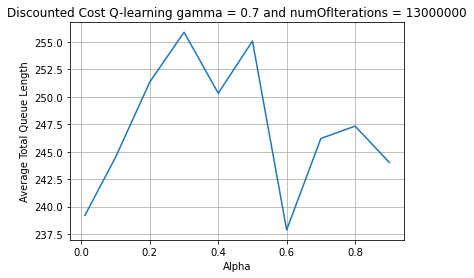

In [9]:
avg_total_q = [239.19707949996766, 244.51743779998034, 251.36041290003087, 255.88072939999404, 250.32691209999578,
              255.07821990000315, 237.87969820000785, 246.20395130000165, 247.33362779998248, 244.03329019998444]
alpha = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.plot(alpha, avg_total_q)
plt.xlabel('Alpha')
plt.ylabel('Average Total Queue Length')
plt.title('Discounted Cost Q-learning gamma = 0.7 and numOfIterations = %d' %train_eps)
plt.grid()
plt.show()

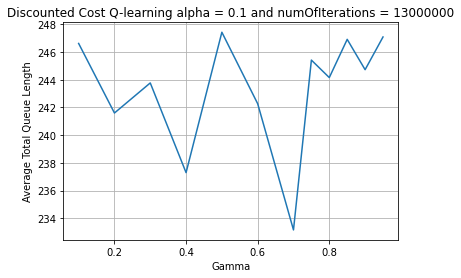

In [17]:
gamma = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
avg_total_q = [246.62907669995414, 241.60148790003157, 243.77524139999298, 237.29234439998947, 247.43927069997102, 
               242.27336269996468, 233.1513695000079, 245.4267292999938, 244.16249309998278, 246.9250727999782, 
               244.73284680002055, 247.0975073999962]
plt.plot(gamma, avg_total_q)
plt.xlabel('Gamma')
plt.ylabel('Average Total Queue Length')
plt.title('Discounted Cost Q-learning alpha = 0.1 and numOfIterations = %d' %train_eps)
plt.grid()
plt.show()